Installing the UMAP library

In [1]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


Importing the libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Load and preprocess the dataset

In [3]:
data = pd.read_csv('ecommerce_diaspora_large_dataset (2).csv')

One-Hot Encoding for categorical features excluding Gender and Age

In [5]:
categorical_features = ['Country', 'Seasonal_Occasion', 'Product_Category']
onehot = OneHotEncoder(sparse_output=False)
X_categorical = onehot.fit_transform(data[categorical_features])

Convert categorical feature names to strings

In [6]:
categorical_feature_names = onehot.get_feature_names_out(categorical_features)
X_categorical_df = pd.DataFrame(X_categorical, columns=categorical_feature_names)

Selecting numerical features

In [7]:
numerical_features = ['Purchase_Frequency', 'Rating']
X_numerical = data[numerical_features]

Combine numerical and categorical features before scaling

In [8]:
X_combined = pd.concat([X_numerical, X_categorical_df], axis=1)

Scaling the combined features

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

Dimensionality reduction with UMAP

In [10]:
umap_model = umap.UMAP(n_neighbors=22, min_dist=0.07, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


DBSCAN Clustering with optimized parameters

In [11]:
dbscan = DBSCAN(eps=0.33, min_samples=22)
clusters_dbscan = dbscan.fit_predict(X_umap)
data['Cluster_DBSCAN'] = clusters_dbscan

Save the dataset with cluster labels

In [12]:
data.to_csv('ecommerce_diaspora_clustered_data.csv', index=False)

Visualizing clusters using a scatter plot

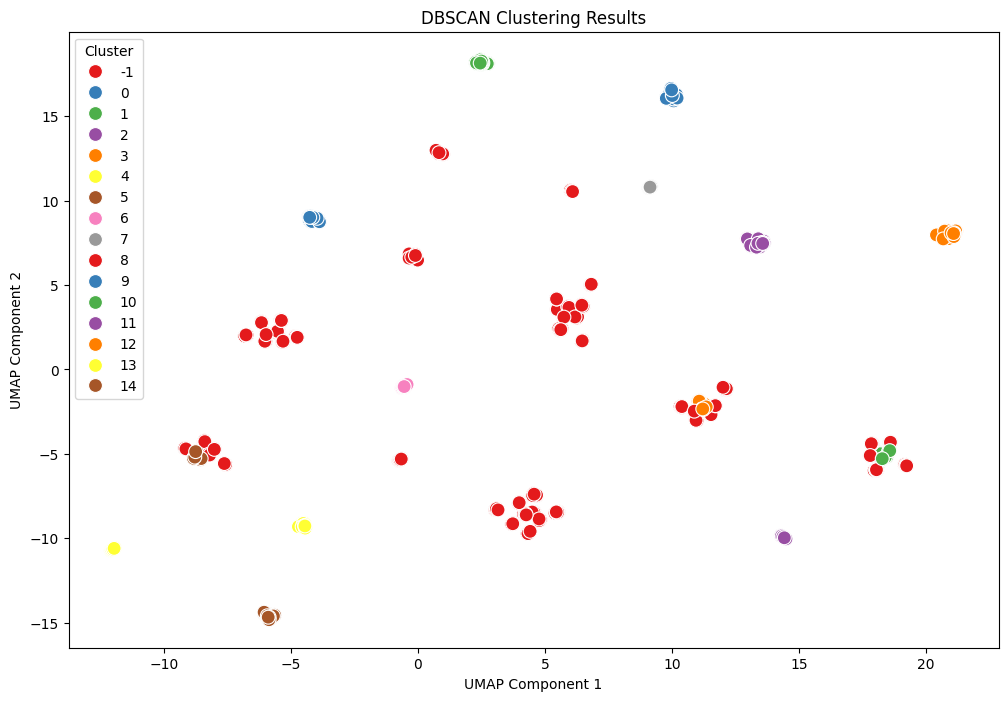

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_dbscan, palette='Set1', s=100, legend='full')
plt.title('DBSCAN Clustering Results')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

Filter out noise points for metric calculation

In [14]:
mask = clusters_dbscan != -1
X_umap_filtered = X_umap[mask]
clusters_dbscan_filtered = clusters_dbscan[mask]

Calculate metrics (for non-noise points only)

In [15]:
if len(set(clusters_dbscan_filtered)) > 1:  # Ensure there is more than one cluster
    silhouette_avg_dbscan = silhouette_score(X_umap_filtered, clusters_dbscan_filtered)
    calinski_harabasz_dbscan = calinski_harabasz_score(X_umap_filtered, clusters_dbscan_filtered)
    davies_bouldin_dbscan = davies_bouldin_score(X_umap_filtered, clusters_dbscan_filtered)

    print(f'Silhouette Score for DBSCAN: {silhouette_avg_dbscan:.2f}')
    print(f'Calinski-Harabasz Index for DBSCAN: {calinski_harabasz_dbscan:.2f}')
    print(f'Davies-Bouldin Index for DBSCAN: {davies_bouldin_dbscan:.2f}')
else:
    print("Not enough clusters for meaningful evaluation.")

Silhouette Score for DBSCAN: 0.96
Calinski-Harabasz Index for DBSCAN: 201746.53
Davies-Bouldin Index for DBSCAN: 0.05


Load the clustered dataset

In [16]:
clustered_data = pd.read_csv('ecommerce_diaspora_clustered_data.csv')

Analyze cluster contents

In [17]:
for cluster_num in range(clustered_data['Cluster_DBSCAN'].nunique()):
    cluster_data = clustered_data[clustered_data['Cluster_DBSCAN'] == cluster_num]
    print(f"Cluster {cluster_num} contains {len(cluster_data)} data points")
    # Mean values for features in each cluster (rounded to 2 decimal points)
    print("Mean values for features in Cluster {}:".format(cluster_num))
    print(cluster_data[numerical_features].mean().round(2))

    # Analyze the distribution of purchase categories in each cluster
    print(f"Purchase Category distribution in Cluster {cluster_num}:")
    category_distribution = cluster_data['Product_Category'].value_counts()
    print(category_distribution)
    print("\n")


Cluster 0 contains 45 data points
Mean values for features in Cluster 0:
Purchase_Frequency    5.27
Rating                3.81
dtype: float64
Purchase Category distribution in Cluster 0:
Product_Category
Bandhanwars    45
Name: count, dtype: int64


Cluster 1 contains 37 data points
Mean values for features in Cluster 1:
Purchase_Frequency    6.05
Rating                3.94
dtype: float64
Purchase Category distribution in Cluster 1:
Product_Category
Torans    37
Name: count, dtype: int64


Cluster 2 contains 23 data points
Mean values for features in Cluster 2:
Purchase_Frequency    5.70
Rating                3.96
dtype: float64
Purchase Category distribution in Cluster 2:
Product_Category
Warli Art    23
Name: count, dtype: int64


Cluster 3 contains 53 data points
Mean values for features in Cluster 3:
Purchase_Frequency    4.77
Rating                3.93
dtype: float64
Purchase Category distribution in Cluster 3:
Product_Category
Puja Samagri of Kumartuli    53
Name: count, dtype: i